Restricted Boltzmann Machines
=============================

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.grid'] = False

from keras.datasets import mnist
from sklearn.neural_network import BernoulliRBM

We consider some utility functions to be used later.

In [2]:
def rbm_gibbs_sample_image(rbm, im, steps):
  assert len(im.shape) < 3
  if len(im.shape) == 2:
    rows = im.shape[0]
    cols = im.shape[1]
    im = im.reshape((-1))
  else:
    im = im.copy()
  for _ in range(steps):
    im = rbm.gibbs(im)
    if len(im.shape) == 2:
      if rows is not None and cols is not None:
        im = im.reshape((rows, cols))
  return im.astype('float32')

def image_palette(X, nr = None, m = 20):
  if nr is None:
    nr = X.shape[0]
  return np.rollaxis(np.rollaxis(X[0:nr].reshape(m, -1, 28, 28), 0, 2), 1, 3).reshape(-1, m * 28)

def remove_rows(X, start, end):
  X = X.copy()
  if len(X.shape) == 2:
    X[start:end] = 0
  elif len(X.shape) == 3:
    X[:,start:end] = 0
  return X

Load the Dataset
----------------
Good ol' MNIST.

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0],-1))
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_test = X_test[0:100]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(-0.5, 559.5, 139.5, -0.5)

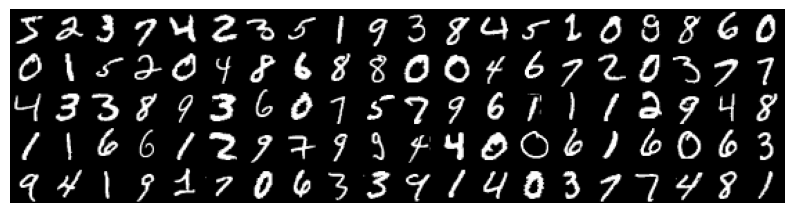

In [4]:
flattened_images = image_palette(X_train, 100)
plt.figure(figsize=(10,20))
plt.imshow(flattened_images)
plt.axis('off')

Train the RBM
-------------
**Exercise** What is the effect of the different parameters: **n_components**, **learning_rate**, **n_iter**. These parameters are, respectively, the number of components, the learning rate and the number of iterations. <br/>
Evaluate the performance visually in the next code cell.


In [5]:
rbm = BernoulliRBM(n_components=10, learning_rate=0.01, random_state=0, n_iter=10, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -196.74, time = 2.54s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -196.54, time = 2.79s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -196.54, time = 2.72s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -196.41, time = 3.15s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -196.40, time = 4.13s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -188.83, time = 2.76s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -187.32, time = 2.70s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -186.71, time = 2.76s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -187.04, time = 4.12s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -187.61, time = 2.86s


BernoulliRBM(learning_rate=0.01, n_components=10, random_state=0, verbose=True)

In [6]:
# It trains multiple RBMs, each with a different set of parameters.

param_sets = [
    {'n_components': 10, 'learning_rate': 0.01, 'n_iter': 10},
    {'n_components': 32, 'learning_rate': 0.01, 'n_iter': 20},
    {'n_components': 64, 'learning_rate': 0.1,  'n_iter': 50},
    {'n_components': 256, 'learning_rate': 0.01, 'n_iter': 200}
]

trained_rbms = []

for params in param_sets:
    print(f"Training RBM with n_components={params['n_components']}, learning_rate={params['learning_rate']}, n_iter={params['n_iter']}")
    rbm_test = BernoulliRBM(n_components=params['n_components'],
                            learning_rate=params['learning_rate'],
                            random_state=0,
                            n_iter=params['n_iter'],
                            verbose=True)
    rbm_test.fit(X_train)
    trained_rbms.append((params, rbm_test))


Training RBM with n_components=10, learning_rate=0.01, n_iter=10
[BernoulliRBM] Iteration 1, pseudo-likelihood = -196.74, time = 2.41s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -196.54, time = 2.70s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -196.54, time = 3.23s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -196.41, time = 3.85s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -196.40, time = 2.71s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -188.83, time = 2.73s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -187.32, time = 2.71s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -186.71, time = 4.26s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -187.04, time = 2.90s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -187.61, time = 2.71s
Training RBM with n_components=32, learning_rate=0.01, n_iter=20
[BernoulliRBM] Iteration 1, pseudo-likelihood = -172.19, time = 3.60s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -151.46, time = 5.79s
[BernoulliRBM] Iteration 3, p

In [11]:
# selecting best rbm from above

rbm = trained_rbms[3][1]

Sample the Trained RBM and Show the Results
-------------------------------------------
The gibbs_steps variable determines how many Gibbs sampling steps will be performed for each test image i.e. with the test images as initialization. <br/>
**Exercise** Try different values and observe the result. Can you explain the result? <br/>
Compare the result with the original test images, shown one cell lower.


(-0.5, 559.5, 139.5, -0.5)

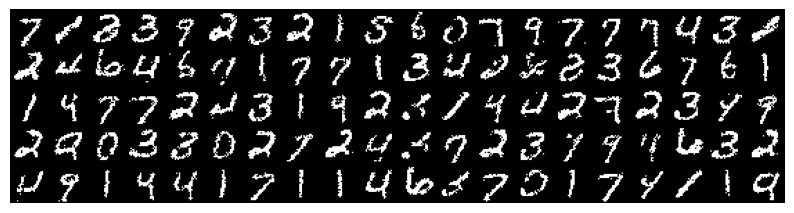

In [12]:
gibbs_steps = 50
a = X_test.copy()
for i in range(a.shape[0]):
  for j in range(gibbs_steps):
    a[i] = rbm.gibbs(a[i])
plt.figure(figsize=(10,20))
plt.imshow(image_palette(a))
plt.axis('off')

(-0.5, 559.5, 139.5, -0.5)

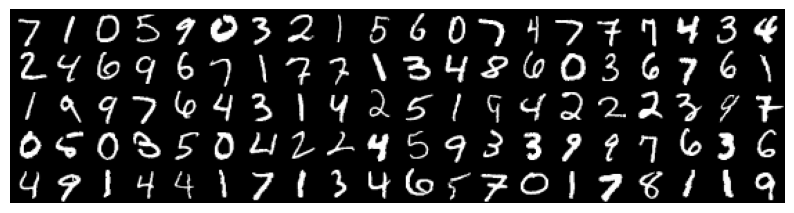

In [13]:
plt.figure(figsize=(10,20))
plt.imshow(image_palette(X_test))
plt.axis('off')

Reconstruction with gibbs_steps = 10


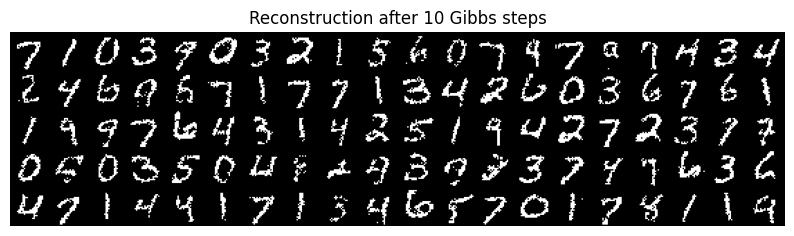

Reconstruction with gibbs_steps = 50


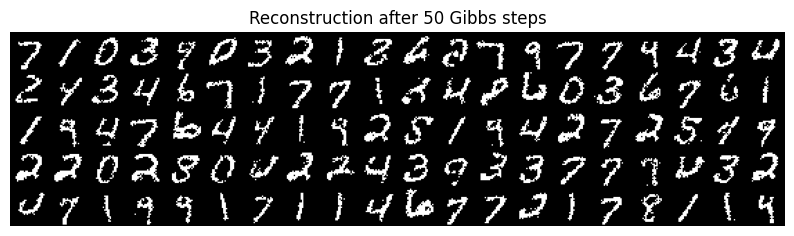

Reconstruction with gibbs_steps = 100


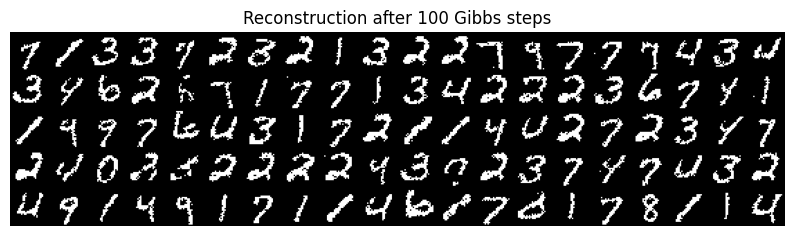

In [14]:
# It uses the already selected RBM (rbm) and performs reconstructions of the test images with different numbers of Gibbs sampling steps.
gibbs_steps_values = [10, 50, 100]
for gs in gibbs_steps_values:
    print(f"Reconstruction with gibbs_steps = {gs}")
    a = X_test.copy()
    for i in range(a.shape[0]):
        for j in range(gs):
            a[i] = rbm.gibbs(a[i])
    plt.figure(figsize=(10,20))
    plt.imshow(image_palette(a))
    plt.title(f"Reconstruction after {gs} Gibbs steps")
    plt.axis('off')
    plt.show()


## Reconstruction of Unseen Images
In this cell, we will remove pixel rows from certain images. Using the recently trained RBM, we will then try to reconstruct the original images.  <br/>
The following variables control this process: <br/>


*   **reconstruction_gibbs_steps**: The number of gibbs steps used to reconstruct the image.
*   **start_test_index**: The first index of the test set to use.
*   **nr**: the number of images starting from **start_test_index** to reconstruct.
*   **start_row_to_remove**:  The index of the first row that should be removed.
*   **end_row_to_remove**: The index up to which the rows should be removed.

**Exercise** Adjust these variables and observe the result of the reconstruction in the shown image.
What is the role of the previously seen RBM hyperparameters on the reconstruction? <br/>
How many rows can you remove such that reconstruction is still possible? <br/>
In the next code cell, the removed rows will be replaced by the reconstructed rows.




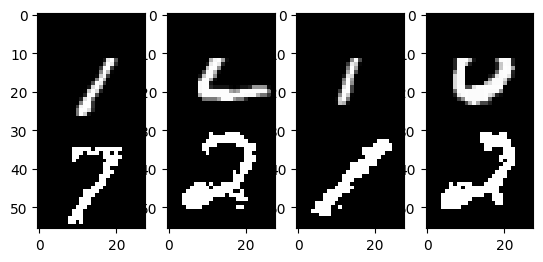

In [15]:
reconstruction_gibbs_steps = 100
start_test_index = 0
nr = 4
start_row_to_remove = 0
end_row_to_remove = 12
to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
to_reconstruct = remove_rows(to_reconstruct, start_row_to_remove, end_row_to_remove)
reconstructed = np.zeros(to_reconstruct.shape)
for i in range(nr):
  reconstructed[i] = rbm_gibbs_sample_image(rbm, to_reconstruct[i], reconstruction_gibbs_steps).reshape((28,28))
combined_images = np.concatenate((to_reconstruct,reconstructed), axis=1)
fig = plt.figure()
for i in range(nr):
  ax1 = fig.add_subplot(1,nr,i+1)
  ax1.imshow(combined_images[i])

plt.show()

Removing rows 0 to 12


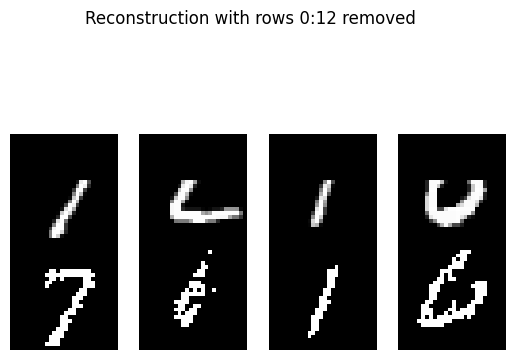

Removing rows 8 to 20


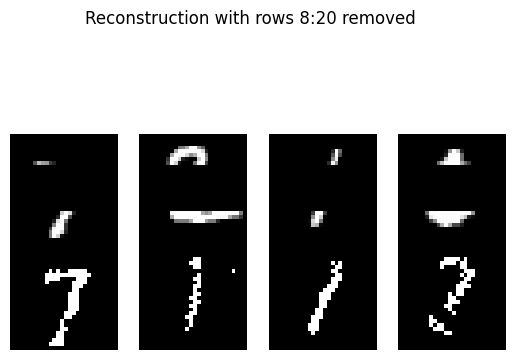

Removing rows 14 to 28


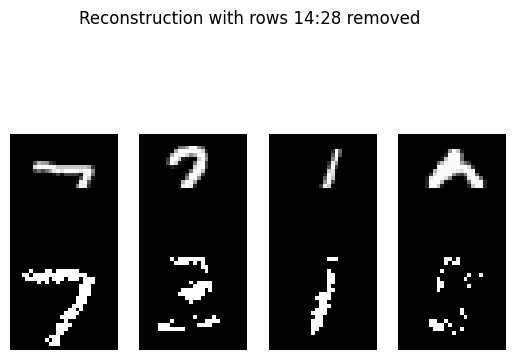

In [16]:
# It tries removing different parts (rows) of the image and attempts to reconstruct them using the same RBM.

row_removal_experiments = [
    {'start_row_to_remove': 0,  'end_row_to_remove': 12},
    {'start_row_to_remove': 8,  'end_row_to_remove': 20},
    {'start_row_to_remove': 14, 'end_row_to_remove': 28}
]

reconstruction_gibbs_steps = 10
start_test_index = 0
nr = 4

for exp in row_removal_experiments:
    print(f"Removing rows {exp['start_row_to_remove']} to {exp['end_row_to_remove']}")
    to_reconstruct = X_test[start_test_index:start_test_index + nr].reshape((-1,28,28))
    to_reconstruct = remove_rows(to_reconstruct, exp['start_row_to_remove'], exp['end_row_to_remove'])
    reconstructed = np.zeros(to_reconstruct.shape)
    for i in range(nr):
        reconstructed[i] = rbm_gibbs_sample_image(rbm, to_reconstruct[i], reconstruction_gibbs_steps).reshape((28,28))
    combined_images = np.concatenate((to_reconstruct,reconstructed), axis=1)
    fig = plt.figure()
    for i in range(nr):
        ax1 = fig.add_subplot(1,nr,i+1)
        ax1.imshow(combined_images[i])
        ax1.axis('off')
    plt.suptitle(f"Reconstruction with rows {exp['start_row_to_remove']}:{exp['end_row_to_remove']} removed")
    plt.show()


## Component Visualization
In the final cell, the components (weights of each neuron) of the RBM are shown.<br/>
Observing these components (think back to CNNs) may offer insights into the trained model.

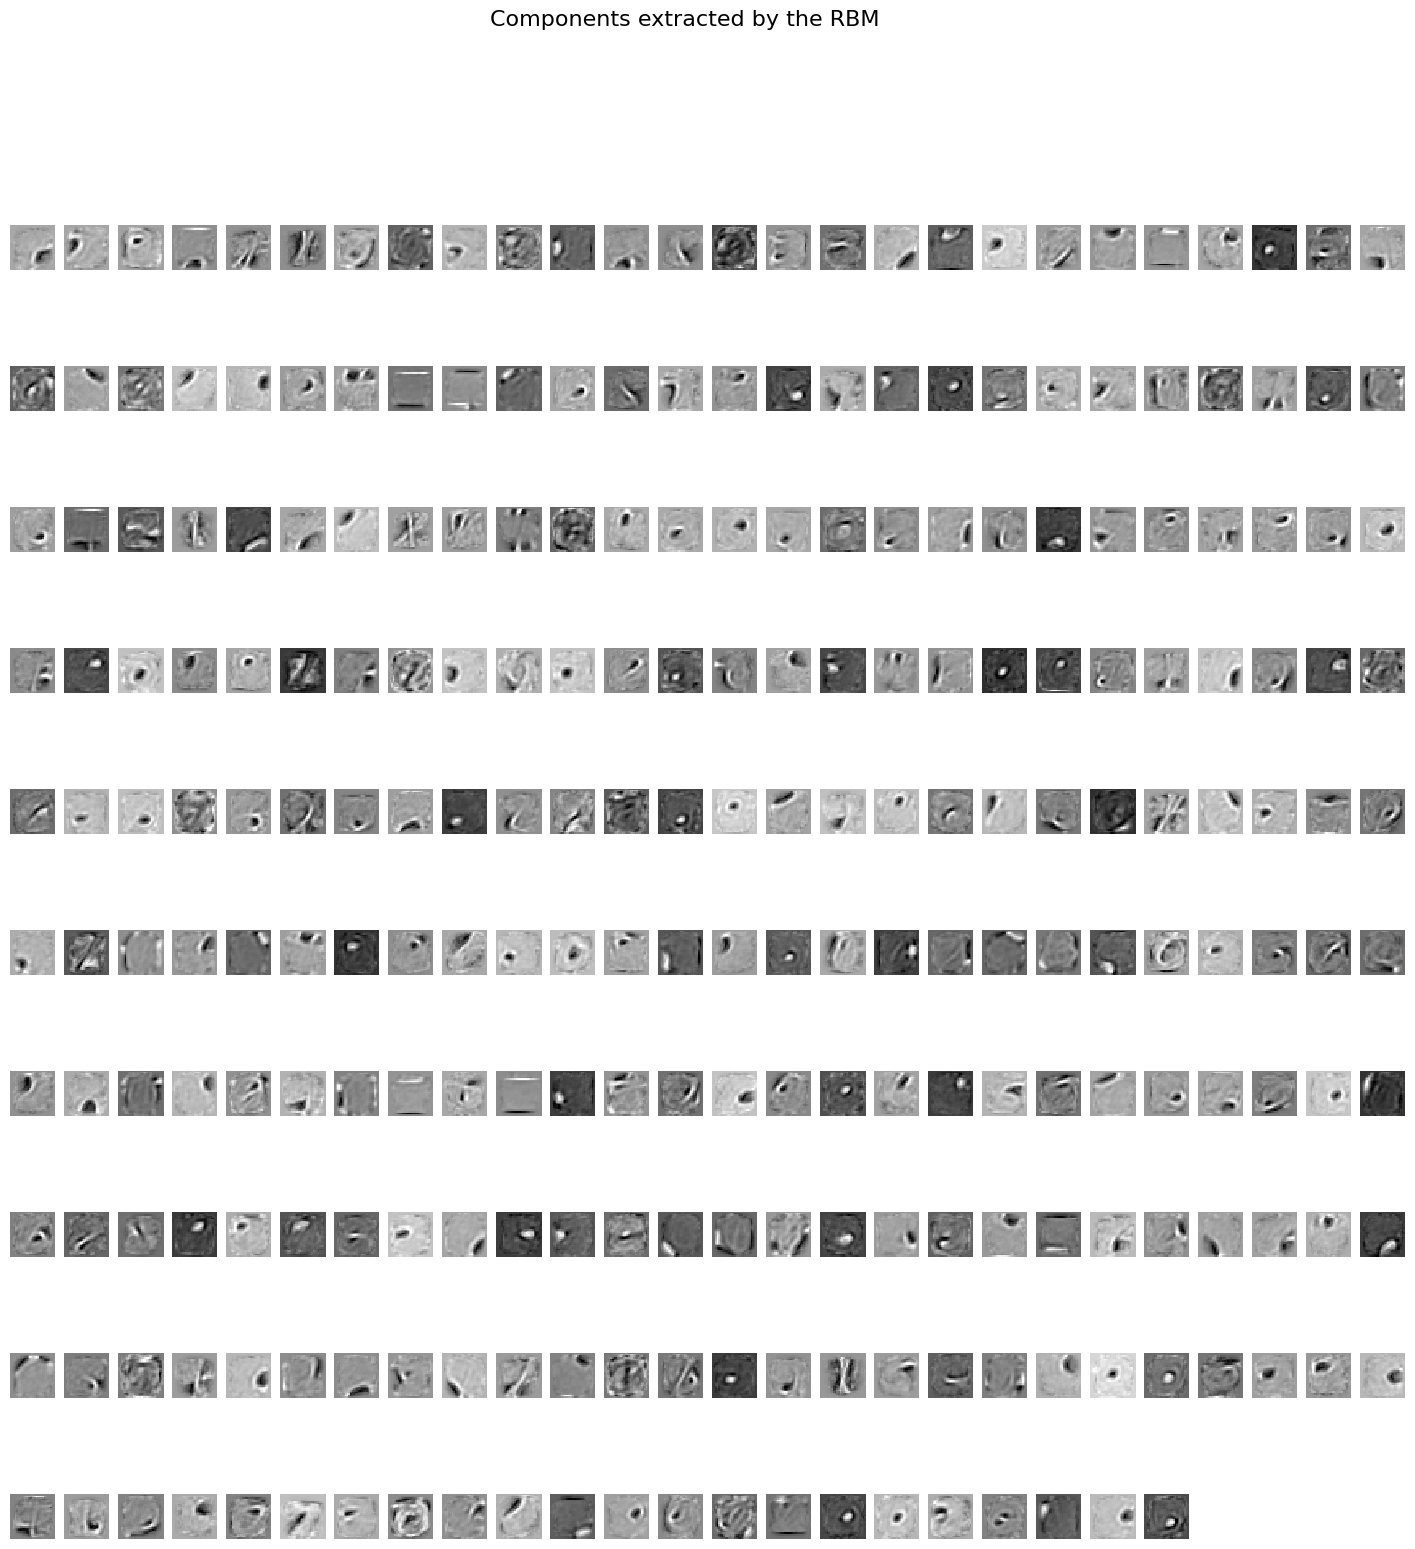

In [17]:
plt.figure(figsize=(18, 18))
nr_components = rbm.components_.shape[0]
for i in range(nr_components):
    c = rbm.components_[i]
    plt.subplot(10, int(np.ceil(nr_components/10)), i + 1)
    plt.imshow(c.reshape((28, 28)), cmap = "gray", interpolation='nearest')
    plt.axis('off')

plt.suptitle('Components extracted by the RBM', fontsize=16);